In [122]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop ,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Activation
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping

DATADIR = './Dataset/Training'
CATEGORIES = ["glioma","meningioma","notumor","pituitary"]

In [123]:
import plotly.express as px
classes_info = {}
classes = sorted(os.listdir(DATADIR))
for name in classes:
    classes_info[name] = len(os.listdir(DATADIR + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='CLasses Info')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


In [124]:
glimoa_train = os.listdir('./Dataset/Training/glioma')
men_train =  os.listdir('./Dataset/Training/meningioma')
notumor_train = os.listdir('./Dataset/Training/notumor')
pit_train =  os.listdir('./Dataset/Training/pituitary')

<AxesSubplot:>

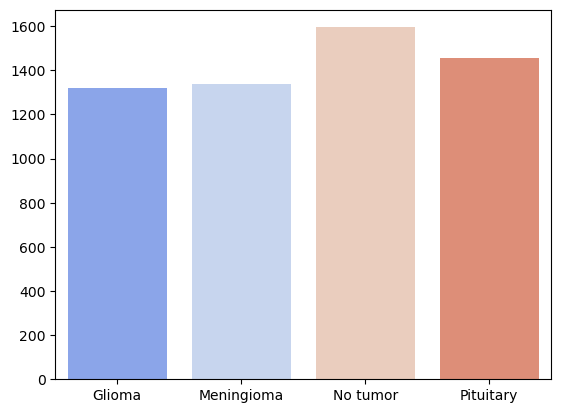

In [125]:
labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
values = [len(glimoa_train), len(men_train), len(notumor_train), len(pit_train)]
sns.barplot(x = labels, y = values, palette="coolwarm")

In [126]:
IMG_SIZE = 140
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [127]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,140,140,1)

(5712, 140, 140)


In [128]:
from keras.utils.np_utils import to_categorical
y = to_categorical(y, num_classes = 4)

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.1, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (5140, 140, 140, 1)
x_test shape (572, 140, 140, 1)
y_train shape (5140, 4)
y_test shape (572, 4)


<AxesSubplot:>

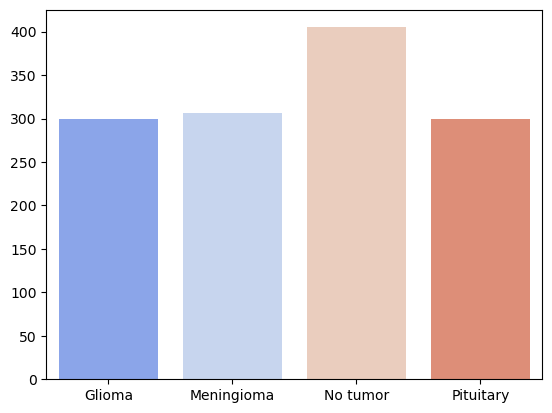

In [130]:
# Test Data Preparation
testDir = './Dataset/Testing'
testCategories = ["glioma","meningioma","notumor","pituitary"]
glimoa_test = os.listdir('./Dataset/Testing/glioma')
men_test =  os.listdir('./Dataset/Testing/meningioma')
notumor_test = os.listdir('./Dataset/Testing/notumor')
pit_test =  os.listdir('./Dataset/Testing/pituitary')
test_labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
test_values = [len(glimoa_test), len(men_test), len(notumor_test), len(pit_test)]
sns.barplot(x = test_labels, y = test_values, palette="coolwarm")

In [131]:
test_classes_info = {}
classes = sorted(os.listdir(testDir))
for name in classes:
    if not name.startswith('.'): 
        test_classes_info[name] = len(os.listdir(testDir + f'/{name}'))
print(test_classes_info)
fig = px.pie(names=test_classes_info.keys(),values=test_classes_info.values(),hole=0.05,title='Test CLasses Info')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [132]:
IMG_SIZE = 140
testing_data = []

def create_testing_data():
    for category in testCategories:
        path = os.path.join(testDir,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                testing_data.append([new_array,class_num])
            except Exception as e:
                pass
create_testing_data()


In [133]:
X_test = []
y_test = []
for features_test,test_labels in testing_data:
    X_test.append(features_test)
    y_test.append(test_labels)
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X_test.shape)
X_test = X_test/255.0  
X_test = X_test.reshape(-1,140,140,1)

y_test = to_categorical(y_test, num_classes = 4)
Y_test = np.argmax(y_test,axis=1)

(1311, 140, 140)


***Base Model Implementation***

In [149]:
# Defining the base model architecture
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),
                 activation ='relu', input_shape = (140,140,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (2,2),
                 activation ='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters = 128, kernel_size = (2,2),
                 activation ='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.01)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 6
batch_size = 40

In [150]:
early_stop=EarlyStopping(monitor='val_loss',patience=3)

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=False,  
        vertical_flip=False) 

history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size, callbacks=[early_stop]) 

Epoch 1/6
128/128 [==============================] - 21s 162ms/step - loss: 1.1154 - accuracy: 0.5080 - val_loss: 0.9405 - val_accuracy: 0.6399
Epoch 2/6
128/128 [==============================] - 21s 164ms/step - loss: 0.7934 - accuracy: 0.6896 - val_loss: 0.8244 - val_accuracy: 0.6713
Epoch 3/6
128/128 [==============================] - 21s 168ms/step - loss: 0.6383 - accuracy: 0.7549 - val_loss: 0.5416 - val_accuracy: 0.7955
Epoch 4/6
128/128 [==============================] - 21s 167ms/step - loss: 0.5458 - accuracy: 0.7945 - val_loss: 0.4970 - val_accuracy: 0.8269
Epoch 5/6
128/128 [==============================] - 22s 169ms/step - loss: 0.4637 - accuracy: 0.8288 - val_loss: 0.4139 - val_accuracy: 0.8497
Epoch 6/6
128/128 [==============================] - 23s 178ms/step - loss: 0.4204 - accuracy: 0.8433 - val_loss: 0.3727 - val_accuracy: 0.8374


In [151]:
# Printing the model summary for base model
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_115 (Conv2D)         (None, 136, 136, 16)      416       
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 68, 68, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_116 (Conv2D)         (None, 66, 66, 32)        4640      
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 33, 33, 32)       0         
 ng2D)                                                           
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                     

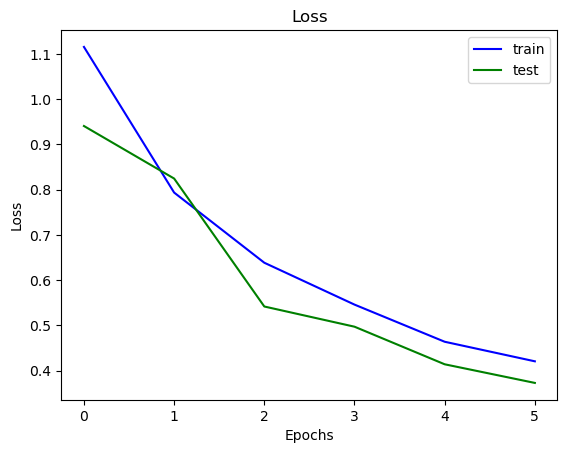

In [152]:
# Printing the loss plot for base model
plt.plot(history.history["loss"],c = "blue")
plt.plot(history.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

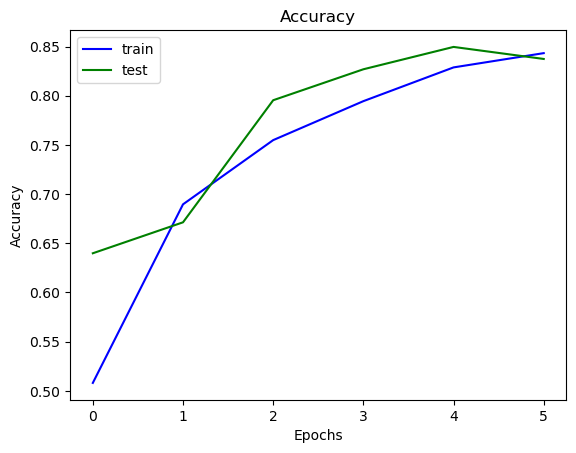

In [153]:
# Printing the accuracy plot for base model
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [154]:
# Evaluating the base model on test data
predict_x_test =model.predict(X_test) 
classes_x_test =np.argmax(predict_x_test,axis=1)
classes_x_test

41/41 [==============================] - 1s 33ms/step


array([1, 0, 1, ..., 3, 3, 2])

In [155]:
# Printing the classification report for base model
print(classification_report(Y_test,classes_x_test,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.93      0.67      0.78       300
  meningioma       0.67      0.69      0.68       306
     notumor       0.88      0.91      0.90       405
   pituitary       0.79      0.96      0.87       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.82      0.82      0.81      1311



Confusion Matrix


Text(98.2222222222222, 0.5, 'Predicted class')

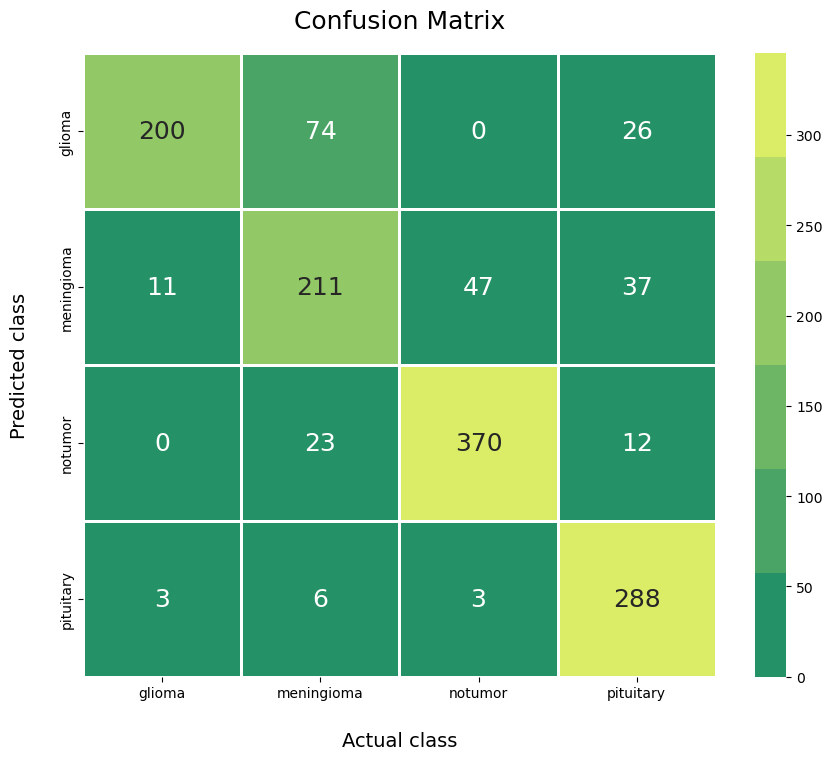

In [156]:
# Printing the confusion matrix for base model
print('Confusion Matrix')
cm = confusion_matrix(Y_test, classes_x_test)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("summer")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

***Tuned Model Implementation***

Model is tuned using early stopping and by setting the epoch count to 8, dropout layers are added to avoid over fitting.

Model has been tuned deploying below tuning concepts:
1. Modifying the number of neurons, filters, batch size, kernel size and activation function
2. Avoiding overfitting using dropout layers
3. Adding padding and strides.


In [114]:
# Defining the architecture of tuned model
model1 = Sequential()

model1.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (140,140,1)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (140,140,1)))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model1.add(Conv2D(filters = 64, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu', input_shape = (80, 80,1)))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu', input_shape = (40,40,1)))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))

model1.add(Flatten())
model1.add(Dense(1024, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation = "softmax"))
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 8
batch_size = 40

In [115]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=False,  
        vertical_flip=False) 

In [116]:
early_stop=EarlyStopping(monitor='val_loss',patience=3)

# Fitting the model with the train data
datagen.fit(X_train)
history1 = model1.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size, callbacks=[early_stop]) 

Epoch 1/8
128/128 [==============================] - 94s 728ms/step - loss: 0.9339 - accuracy: 0.5937 - val_loss: 0.7663 - val_accuracy: 0.6696
Epoch 2/8
128/128 [==============================] - 96s 748ms/step - loss: 0.6021 - accuracy: 0.7696 - val_loss: 0.6593 - val_accuracy: 0.6958
Epoch 3/8
128/128 [==============================] - 106s 829ms/step - loss: 0.4968 - accuracy: 0.8082 - val_loss: 0.5669 - val_accuracy: 0.7587
Epoch 4/8
128/128 [==============================] - 99s 774ms/step - loss: 0.4369 - accuracy: 0.8275 - val_loss: 0.4894 - val_accuracy: 0.7832
Epoch 5/8
128/128 [==============================] - 93s 724ms/step - loss: 0.3751 - accuracy: 0.8545 - val_loss: 0.3827 - val_accuracy: 0.8497
Epoch 6/8
128/128 [==============================] - 91s 708ms/step - loss: 0.3415 - accuracy: 0.8716 - val_loss: 0.3512 - val_accuracy: 0.8654
Epoch 7/8
128/128 [==============================] - 101s 790ms/step - loss: 0.3006 - accuracy: 0.8869 - val_loss: 0.3054 - val_accurac

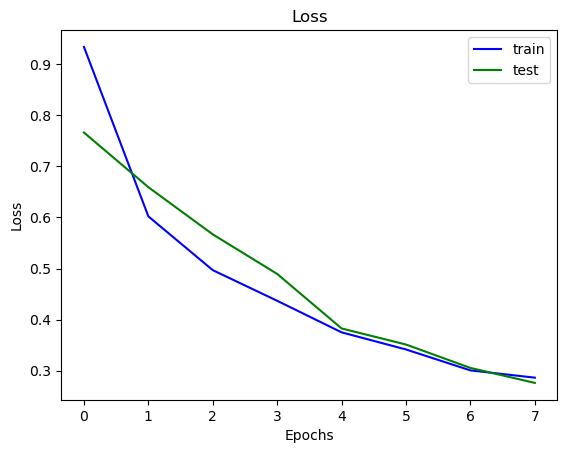

In [117]:
# Printing the loss plot for tuned model
plt.plot(history1.history["loss"],c = "blue")
plt.plot(history1.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

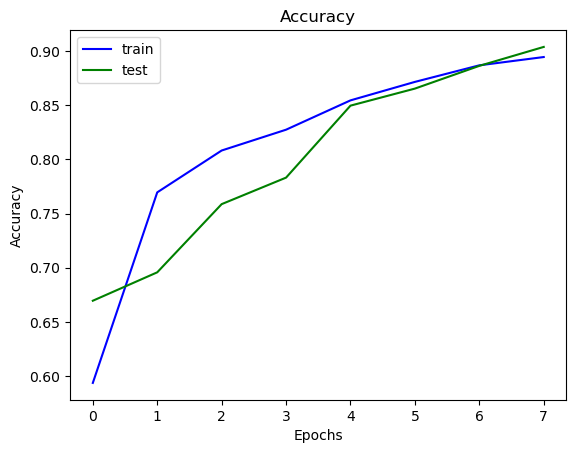

In [118]:
# Printing the accuracy plot for tuned model
plt.plot(history1.history["accuracy"],c = "blue")
plt.plot(history1.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [119]:
# Evaluating tuned model on test data
predict_x_test1 =model1.predict(X_test) 
classes_x_test1 =np.argmax(predict_x_test1,axis=1)
classes_x_test1

41/41 [==============================] - 8s 183ms/step


array([0, 0, 1, ..., 3, 3, 3])

In [120]:
# Printing the classification report of tuned model
print(classification_report(Y_test,classes_x_test1,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.90      0.85      0.88       300
  meningioma       0.86      0.66      0.75       306
     notumor       0.90      0.97      0.93       405
   pituitary       0.83      1.00      0.91       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



Confusion Matrix


Text(98.2222222222222, 0.5, 'Predicted class')

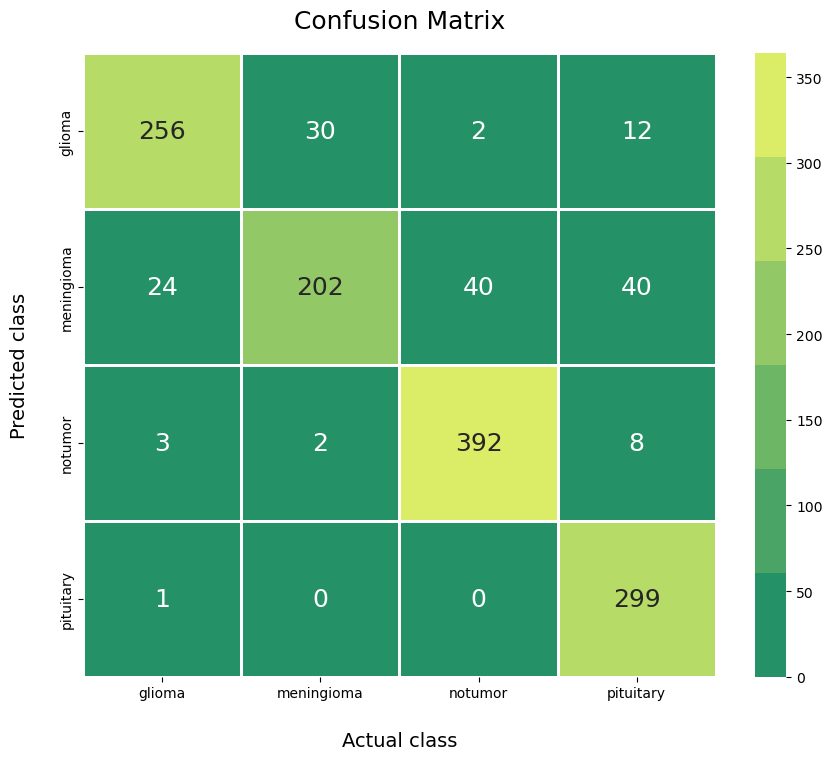

In [121]:
# Printing the confusion matrix of tuned model
print('Confusion Matrix')
cm = confusion_matrix(Y_test, classes_x_test1)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("summer") 
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)